In [613]:
import os
from pathlib import Path
import pandas as pd
import hvplot.pandas
import yfinance as yf
import numpy as np

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [614]:
#Get the ticker names from csv file
csvpath = Path('Resources/Tickers.csv')

ticker = pd.read_csv(csvpath, header=None)

In [615]:
etfs = ticker[0].values

In [616]:
#Function that gets the tickers from yf.
def getData(ticker):

    tickerData = yf.Ticker(ticker)
    
    tickerData_history = tickerData.history(period="max")
    
    tickerData_history = tickerData_history[tickerData_history.index > '2016-01-01']
        
    return tickerData_history 

In [617]:
etf_closing = pd.DataFrame()

#Loop the etfs and save the ticker closing prices into a dataframe
for etf in etfs:
        
    hist = getData(etf)
    
    etf_closing[etf] = hist["Close"]    

- ISBT: No data found, symbol may be delisted
- VQN: 1d data not available for startTime=-2208988800 and endTime=1623377461. Only 100 years worth of day granularity data are allowed to be fetched per request.


In [618]:
#Cleanup
#Get Tickers that have Nulls
nullseries = etf_closing.isnull().sum()
print(nullseries[nullseries > 0])

XGD.TO      26
ZTL.NE     313
XST.TO      26
ISBT      1369
VRE        472
BBU        103
VQN       1369
FTXR       182
FTL       1223
dtype: int64


In [619]:
tickers_dropped = nullseries[nullseries > 0].index

In [620]:
tickers_dropped

Index(['XGD.TO', 'ZTL.NE', 'XST.TO', 'ISBT', 'VRE', 'BBU', 'VQN', 'FTXR',
       'FTL'],
      dtype='object')

In [621]:
#Drop the above tickers
etf_closing.drop(tickers_dropped, axis=1, inplace=True)

In [659]:
etf_closing.head()

,TAN,QCLN,XLE,ICLN,AMLP,VDE,XOP,IEMG,IVV,VOO,...,MCO,COMT,IYK,PSL,IEV,VDC,FSTA,KXI,RHS,PBJ
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,28.486816,15.180246,48.018921,8.728479,37.319801,69.563927,112.901924,33.782635,183.012726,166.546982,...,91.433571,23.346825,95.186722,53.006512,34.409489,111.413399,26.111456,40.639130,102.862846,29.590296
2016-01-05,28.051689,15.247247,48.202087,8.692670,37.074284,69.815010,112.530151,33.861835,183.393204,166.845139,...,92.703247,23.124161,95.525612,53.559555,34.191772,112.069267,26.295403,40.741112,103.491974,29.796633
2016-01-06,27.505468,14.873962,46.346638,8.558387,34.956619,67.103081,104.797661,33.254646,180.992325,164.730637,...,91.047974,22.579866,94.633766,53.378376,33.616966,111.597046,26.216570,40.381947,103.141457,29.684082
2016-01-07,24.987297,14.108252,45.215832,8.245056,33.084499,65.429077,102.195374,32.251461,176.661652,160.718582,...,87.201401,22.233500,92.751976,52.482071,33.007336,110.162827,25.866196,39.854275,101.766373,29.224522
2016-01-08,25.274294,14.041251,44.634518,8.164486,33.728996,64.600418,102.678673,31.943466,174.704666,159.010727,...,84.718544,22.101549,91.904747,52.205551,32.676388,109.305809,25.673492,39.535027,101.101288,29.055700


In [623]:
#Get the total number of etfs
total_etfs = len(etf_closing.columns)

total_etfs

61

In [669]:
def build_model(ticker_df, ticker_name):
    
    #Get returns
    ticker_df['Returns'] = ticker_df.pct_change()
        
    #Gather Signals
    #1) Crossover signal
    ticker_df['crossover_signal'] = signal_crossover(ticker_df)
    
    #Drop nulls
    ticker_df.dropna(inplace=True)
    
    #2) Volatility trend signal
    ticker_df['voltrend_signal'] = signal_voltrend(ticker_df)
    
    display(ticker_df)
    
    #print (ticker_name, ticker_df)
    
    


## Signals

In [679]:
#Trading Signal, Feature One
def signal_crossover(ticker_df):
       
    # Construct Exponential Moving Average of Closing Prices

    # Set short and long windows
    short_window = 1
    long_window = 10

    # Create a new df
    crossover_df = pd.DataFrame(index=ticker_df.index)
    
    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    crossover_df['fast_close'] = ticker_df['Closing'].ewm(halflife=short_window).mean()
    crossover_df['slow_close'] = ticker_df['Closing'].ewm(halflife=long_window).mean()

    # Construct a crossover trading signal
    crossover_df['crossover_long'] = np.where(crossover_df['fast_close'] > crossover_df['slow_close'], 1.0, 0.0)
    crossover_df['crossover_short'] = np.where(crossover_df['fast_close'] < crossover_df['slow_close'], -1.0, 0.0)
    crossover_df['crossover_signal_temp'] = sig_df['crossover_long'] + crossover_df['crossover_short']

    #The following ensures that we have a buy or a sell signal only when there is a switch happening.
    #If a buy or a sell signal doesn't change, we use 0 as hold as oppose to continuosly displaying buy (1) or sell (-1)    
    #The crossover_toggle column is enumerated based on the values in the crossover_signal_temp column, if a signal repeats, it will increase the enumeration until the signal changes.
    crossover_df['crossover_toggle'] = crossover_df.groupby((crossover_df['crossover_signal_temp'] != crossover_df['crossover_signal_temp'].shift(1)).cumsum()).cumcount()+1

    #The actual signal column looks at the toggle column and only grab signal values where the toggle enumeration = 1 (when the switch occurs), otherwise it gets recorded as a hold (0)
    crossover_df['crossover_signal'] = np.where(crossover_df['crossover_toggle'] == 1, crossover_df['crossover_signal_temp'], 0)
    
    
    return crossover_df['crossover_signal']
    
    

In [680]:
#Trading Signal, Feature Two
def signal_voltrend(ticker_df):
    
    #Construct Exponential Moving Average of Daily Return Volatility

    # Set short and long volatility windows
    short_window = 1
    long_window = 10

    # Create a new df
    voltrend_df = pd.DataFrame(index=ticker_df.index)
    
    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    voltrend_df['fast_vol'] = ticker_df['Returns'].ewm(halflife=short_window).std()
    voltrend_df['slow_vol'] = ticker_df['Returns'].ewm(halflife=long_window).std()

    # Construct a vol. trend trading signal
    voltrend_df['vol_trend_long'] = np.where(voltrend_df['fast_vol'] < voltrend_df['slow_vol'], 1.0, 0.0)
    voltrend_df['vol_trend_short'] = np.where(voltrend_df['fast_vol'] > voltrend_df['slow_vol'], -1.0, 0.0) 
    voltrend_df['vol_trend_signal'] = voltrend_df['vol_trend_long'] + voltrend_df['vol_trend_short']

    return voltrend_df['vol_trend_signal']


In [677]:
etf_closing.columns

Index(['TAN', 'QCLN', 'XLE', 'ICLN', 'AMLP', 'VDE', 'XOP', 'IEMG', 'IVV',
       'VOO', 'USRT', 'AACG', 'DGRO', 'IEFA', 'SPY', 'IYR', 'VNQ', 'SCHH',
       'XLRE', 'IWM', 'GLD', 'QQQ', 'VEA', 'VGT', 'VUG', 'SCHA', 'USMV', 'HDV',
       'GDX', 'VAW', 'XME', 'PICK', 'COPX', 'VEU', 'VWO', 'WPP', 'OMC', 'TAL',
       'IPG', 'VIS', 'JETS', 'ITA', 'IYJ', 'FXR', 'XAR', 'FIDU', 'PPA', 'CORN',
       'USO', 'DBB', 'SPGI', 'MCO', 'COMT', 'IYK', 'PSL', 'IEV', 'VDC', 'FSTA',
       'KXI', 'RHS', 'PBJ'],
      dtype='object')

In [630]:
etf_closing.columns[50]

'SPGI'

In [657]:
#etf_closing

In [681]:
#for i in range(0, total_etfs):
for i in range(50, 51):
    
    ticker_name = etf_closing.columns[i]
    
    ticker_df = pd.DataFrame()    
    ticker_df['Closing'] = etf_closing.iloc[:,i]
    
    build_model(ticker_df, ticker_name)
    

,Closing,Returns,crossover_signal,voltrend_signal
Date,,,,
2016-01-05,89.795204,0.003375,1.0,0.0
2016-01-06,88.813446,-0.010933,-1.0,0.0
2016-01-07,86.019112,-0.031463,0.0,1.0
2016-01-08,83.555260,-0.028643,0.0,1.0
2016-01-11,83.517471,-0.000452,0.0,-1.0
...,...,...,...,...
2021-06-04,384.579987,0.008470,0.0,1.0
2021-06-07,381.230011,-0.008711,0.0,1.0
2021-06-08,384.390015,0.008289,0.0,1.0


In [595]:
# Get returns
#etf_returns = etf_df.pct_change()

#cumulative_returns = (1+etf_returns).cumprod()

#cumulative_returns.plot(figsize=(20, 20))

In [598]:
#etf_returns.dropna(inplace=True)

#etf_returns

In [660]:
#etf_closing

In [661]:
# sig_df = pd.DataFrame(index = etf_closing.index)
# sig_df['Close'] = etf_closing['SPGI']

# sig_df

In [663]:
### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

# Set short and long windows
# short_window = 1
# long_window = 10

# # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
# sig_df['fast_close'] = sig_df['Close'].ewm(halflife=short_window).mean()
# sig_df['slow_close'] = sig_df['Close'].ewm(halflife=long_window).mean()

# # Construct a crossover trading signal
# sig_df['crossover_long'] = np.where(sig_df['fast_close'] > sig_df['slow_close'], 1.0, 0.0)
# sig_df['crossover_short'] = np.where(sig_df['fast_close'] < sig_df['slow_close'], -1.0, 0.0)
# sig_df['crossover_signal'] = sig_df['crossover_long'] + sig_df['crossover_short']

# sig_df

In [179]:
### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
sig_df['fast_close'] = sig_df['Close'].ewm(halflife=short_window).mean()
sig_df['slow_close'] = sig_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
sig_df['crossover_long'] = np.where(sig_df['fast_close'] > sig_df['slow_close'], 1.0, 0.0)
sig_df['crossover_short'] = np.where(sig_df['fast_close'] < sig_df['slow_close'], -1.0, 0.0)
sig_df['crossover_signal'] = sig_df['crossover_long'] + sig_df['crossover_short']

sig_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,
2016-01-05,89.795204,0.003375,89.795204,89.795204,0.0,0.0,0.0
2016-01-06,88.813446,-0.010933,89.140699,89.287319,0.0,-1.0,-1.0
2016-01-07,86.019112,-0.031463,87.356935,88.121594,0.0,-1.0,-1.0
2016-01-08,83.555260,-0.028643,85.329375,86.858723,0.0,-1.0,-1.0
2016-01-11,83.517471,-0.000452,84.394199,86.094780,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...
2021-05-28,379.470001,-0.002812,379.394469,376.998416,1.0,0.0,1.0
2021-06-01,373.459991,-0.015838,376.427230,376.761458,0.0,-1.0,-1.0
2021-06-02,379.829987,0.017057,378.128608,376.966949,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

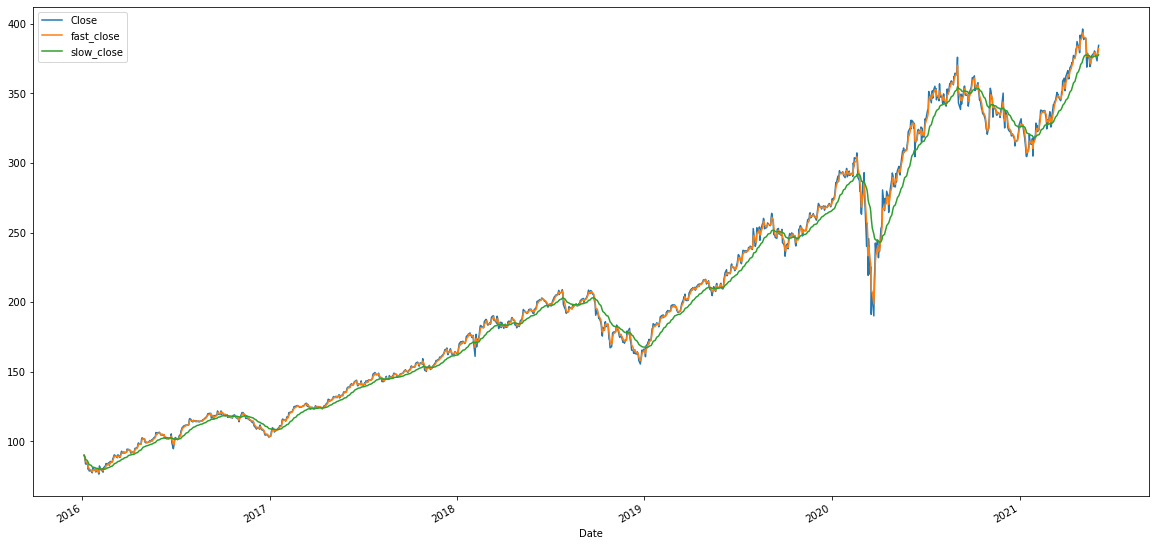

In [180]:
### Plot Exponential Moving Average of Closing Prices
sig_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [181]:
### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
sig_df['fast_vol'] = sig_df['daily_return'].ewm(halflife=short_vol_window).std()
sig_df['slow_vol'] = sig_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
sig_df['vol_trend_long'] = np.where(sig_df['fast_vol'] < sig_df['slow_vol'], 1.0, 0.0)
sig_df['vol_trend_short'] = np.where(sig_df['fast_vol'] > sig_df['slow_vol'], -1.0, 0.0) 
sig_df['vol_trend_signal'] = sig_df['vol_trend_long'] + sig_df['vol_trend_short']



sig_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,
2016-01-05,89.795204,0.003375,89.795204,89.795204,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2016-01-06,88.813446,-0.010933,89.140699,89.287319,0.0,-1.0,-1.0,0.010118,0.010118,0.0,0.0,0.0
2016-01-07,86.019112,-0.031463,87.356935,88.121594,0.0,-1.0,-1.0,0.017562,0.017576,1.0,0.0,1.0
2016-01-08,83.555260,-0.028643,85.329375,86.858723,0.0,-1.0,-1.0,0.012567,0.016047,1.0,0.0,1.0
2016-01-11,83.517471,-0.000452,84.394199,86.094780,0.0,-1.0,-1.0,0.017466,0.015927,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28,379.470001,-0.002812,379.394469,376.998416,1.0,0.0,1.0,0.004445,0.011811,1.0,0.0,1.0
2021-06-01,373.459991,-0.015838,376.427230,376.761458,0.0,-1.0,-1.0,0.010318,0.012149,1.0,0.0,1.0
2021-06-02,379.829987,0.017057,378.128608,376.966949,1.0,0.0,1.0,0.016887,0.012559,0.0,-1.0,-1.0


In [260]:
#sig_df[['crossover_signal']]

sig_df['crossover_toggle'] = sig_df.groupby((sig_df['crossover_signal'] != sig_df['crossover_signal'].shift(1)).cumsum()).cumcount()+1

sig_df[['crossover_signal', 'crossover_toggle']]
#final_df.groupby((final_df['low_equity'] != final_df['low_equity'].shift(1)).cumsum()).cumcount()+1




,crossover_signal,crossover_toggle
Date,,
2016-01-06,0.0,1
2016-01-07,-1.0,1
2016-01-08,-1.0,2
2016-01-11,-1.0,3
2016-01-12,-1.0,4
...,...,...
2021-05-28,1.0,4
2021-06-01,1.0,5
2021-06-02,-1.0,1


In [262]:
sig_df['crossover_real'] = np.where(sig_df['crossover_toggle'] == 1, sig_df['crossover_signal'], 0)

In [265]:
sig_df[['crossover_signal', 'crossover_toggle', 'crossover_real']]

,crossover_signal,crossover_toggle,crossover_real
Date,,,
2016-01-06,0.0,1,0.0
2016-01-07,-1.0,1,-1.0
2016-01-08,-1.0,2,0.0
2016-01-11,-1.0,3,0.0
2016-01-12,-1.0,4,0.0
...,...,...,...
2021-05-28,1.0,4,0.0
2021-06-01,1.0,5,0.0
2021-06-02,-1.0,1,-1.0


<AxesSubplot:xlabel='Date'>

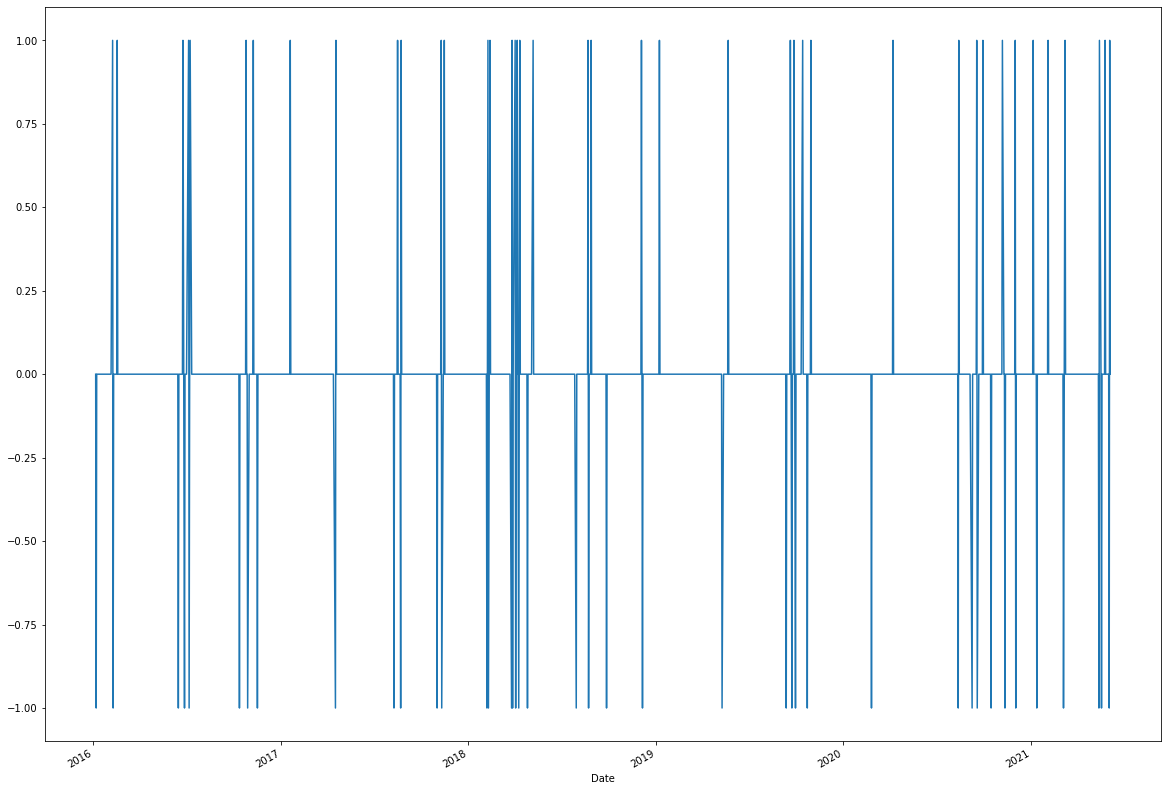

In [268]:
sig_df['crossover_real'].plot(figsize=(20, 15))

<AxesSubplot:xlabel='Date'>

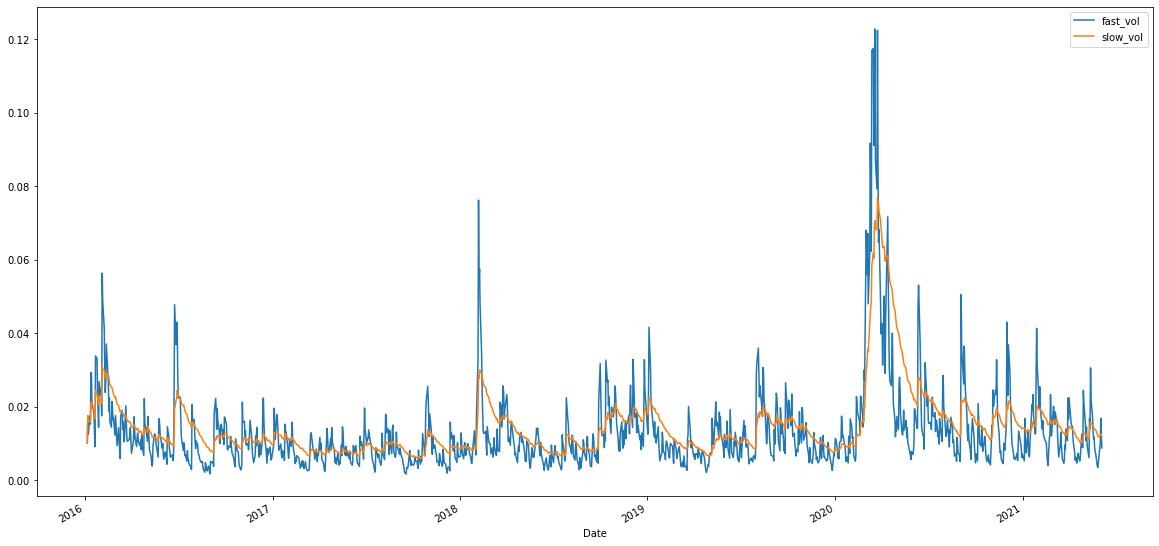

In [182]:
### Plot Exponential Moving Average of Daily Return Volatility
sig_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,...,closing_bollinger_upper,closing_bollinger_lower,bollinger_long,bollinger_short,bollinger_signal,Positive Return,crossover_toggle,crossover_real,closing_bollinger_mod_upper,closing_bollinger_mod_lower
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-06,88.813446,-0.010933,89.140699,89.287319,0.0,-1.0,0.0,0.010118,0.010118,0.0,...,NaN,NaN,0,0,0,0.0,1,0.0,NaN,NaN
2016-01-07,86.019112,-0.031463,87.356935,88.121594,0.0,-1.0,-1.0,0.017562,0.017576,1.0,...,NaN,NaN,0,0,0,0.0,1,-1.0,NaN,NaN
2016-01-08,83.555260,-0.028643,85.329375,86.858723,0.0,-1.0,-1.0,0.012567,0.016047,1.0,...,NaN,NaN,0,0,0,0.0,2,0.0,NaN,NaN
2016-01-11,83.517471,-0.000452,84.394199,86.094780,0.0,-1.0,-1.0,0.017466,0.015927,0.0,...,NaN,NaN,0,0,0,0.0,3,0.0,NaN,NaN
2016-01-12,83.753471,0.002826,84.068750,85.633966,0.0,-1.0,-1.0,0.015315,0.015781,1.0,...,NaN,NaN,0,0,0,1.0,4,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28,379.470001,-0.002812,379.394469,376.998416,1.0,0.0,1.0,0.004445,0.011811,1.0,...,396.936854,364.426223,0,0,0,0.0,4,0.0,401.000683,360.362394
2021-06-01,373.459991,-0.015838,376.427230,376.761458,0.0,-1.0,1.0,0.010318,0.012149,1.0,...,395.149080,364.250013,0,0,0,0.0,5,0.0,399.011464,360.387630
2021-06-02,379.829987,0.017057,378.128608,376.966949,1.0,0.0,-1.0,0.016887,0.012559,0.0,...,392.203410,365.546355,0,0,0,1.0,1,-1.0,395.535541,362.214224


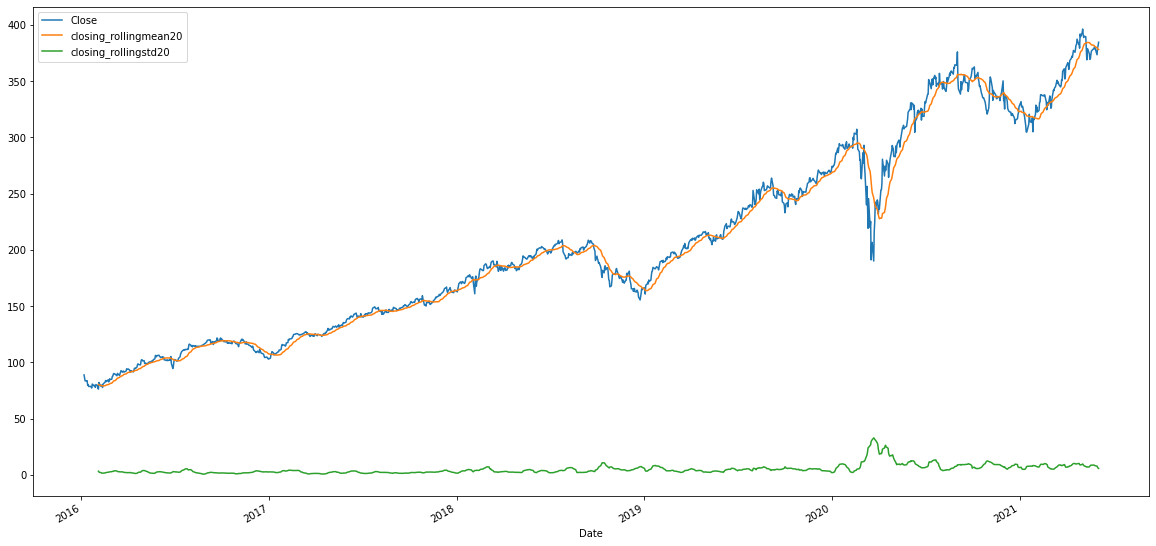

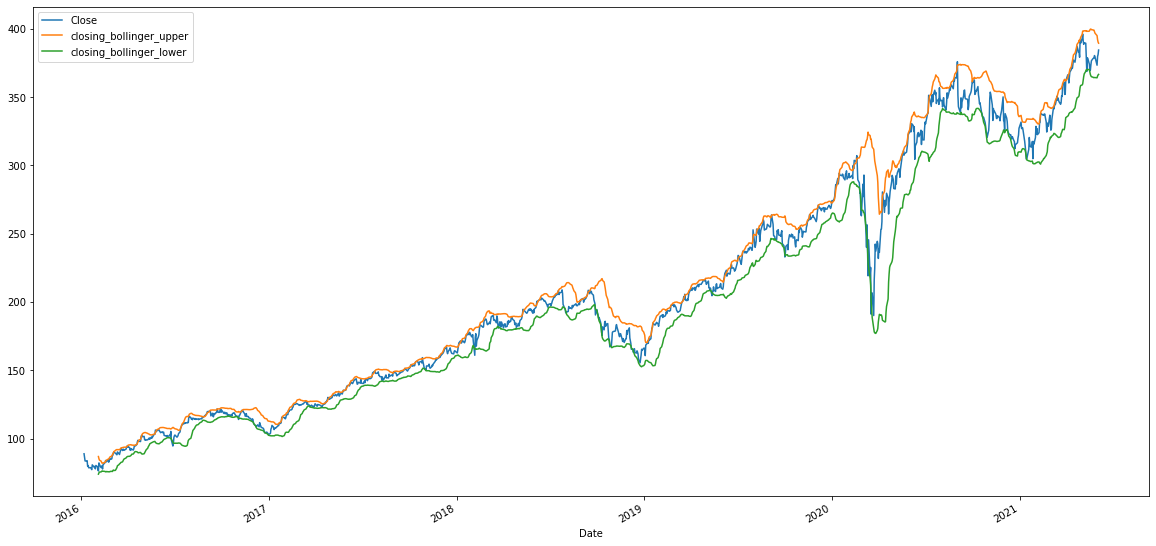

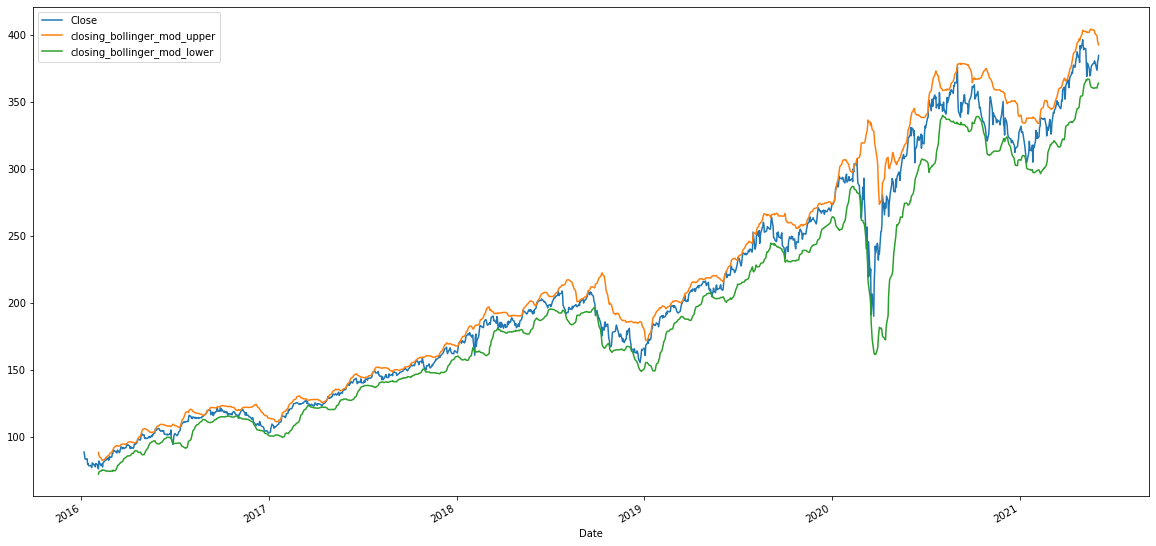

In [270]:
#Bolinger signal

sig_df["closing_rollingmean20"] = sig_df['Close'].rolling(20).mean()
sig_df["closing_rollingstd20"] = sig_df['Close'].rolling(20).std()

sig_df[["Close","closing_rollingmean20", "closing_rollingstd20"]].plot(figsize=(20, 10))

sig_df["closing_bollinger_upper"] = sig_df["closing_rollingmean20"] + (sig_df["closing_rollingstd20"] * 2)
sig_df["closing_bollinger_lower"] = sig_df["closing_rollingmean20"] - (sig_df["closing_rollingstd20"] * 2)

sig_df["closing_bollinger_mod_upper"] = sig_df["closing_rollingmean20"] + (sig_df["closing_rollingstd20"] * 2.5)
sig_df["closing_bollinger_mod_lower"] = sig_df["closing_rollingmean20"] - (sig_df["closing_rollingstd20"] * 2.5)

sig_df[["Close","closing_bollinger_upper", "closing_bollinger_lower"]].plot(figsize=(20, 10))

sig_df[["Close","closing_bollinger_mod_upper", "closing_bollinger_mod_lower"]].plot(figsize=(20, 10))




##Buying
sig_df["bollinger_long"] = np.where(sig_df["Close"] < sig_df["closing_bollinger_lower"], 1, 0)

##Selling
sig_df["bollinger_short"] = np.where(sig_df["Close"] > sig_df["closing_bollinger_upper"], -1, 0)


sig_df["bollinger_signal"] = sig_df["bollinger_long"] + sig_df["bollinger_short"]



sig_df


In [272]:
x_var_list = ['crossover_real', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
sig_df[x_var_list].tail()

,crossover_real,vol_trend_signal,bollinger_signal
Date,,,
2021-05-28,0.0,1.0,0
2021-06-01,0.0,1.0,0
2021-06-02,-1.0,1.0,0
2021-06-03,1.0,-1.0,0
2021-06-04,0.0,1.0,0


In [273]:
# Shift DataFrame values by 1
sig_df[x_var_list] = sig_df[x_var_list].shift(1)
sig_df[x_var_list].tail()

,crossover_real,vol_trend_signal,bollinger_signal
Date,,,
2021-05-28,0.0,1.0,0.0
2021-06-01,0.0,1.0,0.0
2021-06-02,0.0,1.0,0.0
2021-06-03,-1.0,1.0,0.0
2021-06-04,1.0,-1.0,0.0


In [187]:
# Drop NAs and replace positive/negative infinity values
sig_df.dropna(subset=x_var_list, inplace=True)
sig_df.dropna(subset=['daily_return'], inplace=True)
sig_df = sig_df.replace([np.inf, -np.inf], np.nan)
sig_df.head()

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,closing_rollingmean20,closing_rollingstd20,closing_bollinger_upper,closing_bollinger_lower,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
2016-01-06,88.813446,-0.010933,89.140699,89.287319,0.0,-1.0,0.0,0.010118,0.010118,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0
2016-01-07,86.019112,-0.031463,87.356935,88.121594,0.0,-1.0,-1.0,0.017562,0.017576,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0
2016-01-08,83.555260,-0.028643,85.329375,86.858723,0.0,-1.0,-1.0,0.012567,0.016047,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0
2016-01-11,83.517471,-0.000452,84.394199,86.094780,0.0,-1.0,-1.0,0.017466,0.015927,0.0,-1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0
2016-01-12,83.753471,0.002826,84.068750,85.633966,0.0,-1.0,-1.0,0.015315,0.015781,1.0,0.0,-1.0,NaN,NaN,NaN,NaN,0,0,0.0


In [188]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.

# Daily return - set a threshold (if daily return more than $5) or a pct of close.

sig_df['Positive Return'] = np.where(sig_df['daily_return'] > 0, 1.0, 0.0)
sig_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,closing_rollingmean20,closing_rollingstd20,closing_bollinger_upper,closing_bollinger_lower,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,
2016-01-06,88.813446,-0.010933,89.140699,89.287319,0.0,-1.0,0.0,0.010118,0.010118,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-07,86.019112,-0.031463,87.356935,88.121594,0.0,-1.0,-1.0,0.017562,0.017576,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-08,83.555260,-0.028643,85.329375,86.858723,0.0,-1.0,-1.0,0.012567,0.016047,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-11,83.517471,-0.000452,84.394199,86.094780,0.0,-1.0,-1.0,0.017466,0.015927,0.0,-1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-12,83.753471,0.002826,84.068750,85.633966,0.0,-1.0,-1.0,0.015315,0.015781,1.0,0.0,-1.0,NaN,NaN,NaN,NaN,0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28,379.470001,-0.002812,379.394469,376.998416,1.0,0.0,1.0,0.004445,0.011811,1.0,0.0,1.0,380.681538,8.127658,396.936854,364.426223,0,0,0.0,0.0
2021-06-01,373.459991,-0.015838,376.427230,376.761458,0.0,-1.0,1.0,0.010318,0.012149,1.0,0.0,1.0,379.699547,7.724767,395.149080,364.250013,0,0,0.0,0.0
2021-06-02,379.829987,0.017057,378.128608,376.966949,1.0,0.0,-1.0,0.016887,0.012559,0.0,-1.0,1.0,378.874883,6.664264,392.203410,365.546355,0,0,0.0,1.0


In [277]:
# def rfr_model(X, y):
# # Perform Grid-Search
#     gsc = GridSearchCV(
#         estimator=RandomForestRegressor(),
#         param_grid={'max_depth': range(3,7),
#                     'n_estimators': (10, 50, 100, 1000),
#                    },cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
#     )
#     grid_result = gsc.fit(X, y)
#     best_params = grid_result.best_params_
#     rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],
#                                 random_state=False, verbose=False)
#         # Perform K-Fold CV
#     scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

#     return scores

In [278]:
#  # Construct training start and end dates
# training_start = sig_df.index.min().strftime(format= '%Y-%m-%d')
# training_end = '2019-01-01'

# # Construct testing start and end dates
# testing_start =  '2019-01-02'
# #testing_end = sig_df.index.max().strftime(format= '%Y-%m-%d')
# testing_end = '2020-01-01'

# # Print training and testing start/end dates
# print(f"Training Start: {training_start}")
# print(f"Training End: {training_end}")
# print(f"Testing Start: {testing_start}")
# print(f"Testing End: {testing_end}")

In [279]:
# Construct the X_train and y_train datasets
# X_train = sig_df[x_var_list][training_start:training_end]
# y_train = sig_df['Positive Return'][training_start:training_end]

# X_train.tail()

In [306]:
var_list = ['crossover_real', 'vol_trend_signal', 'bollinger_signal', 'Positive Return']


fl_df = sig_df[var_list]


fl_df.dropna(inplace = True)

X = fl_df[x_var_list]

y = fl_df['Positive Return']



/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [307]:
X

,crossover_real,vol_trend_signal,bollinger_signal
Date,,,
2016-01-07,0.0,0.0,0.0
2016-01-08,-1.0,0.0,0.0
2016-01-11,0.0,1.0,0.0
2016-01-12,0.0,1.0,0.0
2016-01-13,0.0,-1.0,0.0
...,...,...,...
2021-05-28,0.0,1.0,0.0
2021-06-01,0.0,1.0,0.0
2021-06-02,0.0,1.0,0.0


In [308]:
y

Date
2016-01-07    0.0
2016-01-08    0.0
2016-01-11    0.0
2016-01-12    1.0
2016-01-13    0.0
             ... 
2021-05-28    0.0
2021-06-01    0.0
2021-06-02    1.0
2021-06-03    1.0
2021-06-04    1.0
Name: Positive Return, Length: 1362, dtype: float64

In [434]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     test_size = 0.25,
#                                                     random_state = 50)


In [435]:
# print('Training Features Shape:', X_train.shape)
# print('Training Labels Shape:', y_train.shape)
# print('Testing Features Shape:', X_test.shape)
# print('Testing Labels Shape:', y_test.shape)

In [333]:
# Import the model we are using
#from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X, y);

In [335]:
# Use the forest's predict method on the test data
predictions = rf.predict(X)
# Calculate the absolute errors


Mean Absolute Error: 0.49 degrees.


In [339]:
fl_df

,crossover_real,vol_trend_signal,bollinger_signal,Positive Return
Date,,,,
2016-01-07,0.0,0.0,0.0,0.0
2016-01-08,-1.0,0.0,0.0,0.0
2016-01-11,0.0,1.0,0.0,0.0
2016-01-12,0.0,1.0,0.0,1.0
2016-01-13,0.0,-1.0,0.0,0.0
...,...,...,...,...
2021-05-28,0.0,1.0,0.0,0.0
2021-06-01,0.0,1.0,0.0,0.0
2021-06-02,0.0,1.0,0.0,1.0


In [340]:
fl_df['predictions'] = predictions

/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [341]:
fl_df

,crossover_real,vol_trend_signal,bollinger_signal,Positive Return,predictions
Date,,,,,
2016-01-07,0.0,0.0,0.0,0.0,0.147582
2016-01-08,-1.0,0.0,0.0,0.0,0.122734
2016-01-11,0.0,1.0,0.0,0.0,0.570809
2016-01-12,0.0,1.0,0.0,1.0,0.570809
2016-01-13,0.0,-1.0,0.0,0.0,0.533484
...,...,...,...,...,...
2021-05-28,0.0,1.0,0.0,0.0,0.570809
2021-06-01,0.0,1.0,0.0,0.0,0.570809
2021-06-02,0.0,1.0,0.0,1.0,0.570809


In [342]:
possible_thresholds = np.arange(0,1,0.1)

In [343]:
possible_thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [402]:
#0.3, and 0.4  gives us the best threshold (highest f1 score)
current_threshold = possible_thresholds[3]

In [425]:
fl_df['y_predbinary'] = np.where(fl_df['predictions'] > current_threshold, 1, 0)

/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [426]:
vv

,crossover_real,vol_trend_signal,bollinger_signal,Positive Return,predictions,y_predbinary
Date,,,,,,
2016-01-07,0.0,0.0,0.0,0.0,0.147582,0
2016-01-08,-1.0,0.0,0.0,0.0,0.122734,0
2016-01-11,0.0,1.0,0.0,0.0,0.570809,1
2016-01-12,0.0,1.0,0.0,1.0,0.570809,1
2016-01-13,0.0,-1.0,0.0,0.0,0.533484,1
...,...,...,...,...,...,...
2021-05-28,0.0,1.0,0.0,0.0,0.570809,1
2021-06-01,0.0,1.0,0.0,0.0,0.570809,1
2021-06-02,0.0,1.0,0.0,1.0,0.570809,1


In [427]:
from sklearn.metrics import f1_score

f1_score(fl_df['Positive Return'], fl_df['y_predbinary'])

0.7149621212121211

In [410]:
import matplotlib.pyplot as plt 


In [490]:
def assign_threshold(x):
    
    if x < 0.2:
        
        return 'sell'
    
    elif x >= 0.2 and x < 0.5:
        
        return 'hold'
    
    else:
                
        return 'buy'
    
       
    
    
    
        
        

In [491]:
fl_df['final_prediction'] = fl_df['predictions'].apply(assign_threshold)

/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [492]:
fl_df

,crossover_real,vol_trend_signal,bollinger_signal,Positive Return,predictions,y_predbinary,final_prediction
Date,,,,,,,
2016-01-07,0.0,0.0,0.0,0.0,0.147582,0,sell
2016-01-08,-1.0,0.0,0.0,0.0,0.122734,0,sell
2016-01-11,0.0,1.0,0.0,0.0,0.570809,0,buy
2016-01-12,0.0,1.0,0.0,1.0,0.570809,0,buy
2016-01-13,0.0,-1.0,0.0,0.0,0.533484,0,buy
...,...,...,...,...,...,...,...
2021-05-28,0.0,1.0,0.0,0.0,0.570809,0,buy
2021-06-01,0.0,1.0,0.0,0.0,0.570809,0,buy
2021-06-02,0.0,1.0,0.0,1.0,0.570809,0,buy


In [ ]:
#Scatter plot

In [505]:
f1_scores = []
for threshold in possible_thresholds:
    fl_df['y_predbinary'] = np.where(fl_df['predictions'] > threshold, 1, 0)
    f1_scores.append(f1_score(fl_df['Positive Return'], fl_df['y_predbinary'])) 
    
    

/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-pac

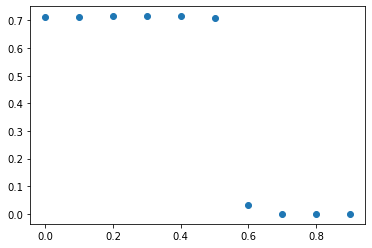

In [515]:
plt.scatter(possible_thresholds, f1_scores)


In [430]:
predictions = fl_df['y_predbinary']

In [516]:


# errors = abs(predictions - y)
# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


In [517]:
# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / y)
# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

In [433]:
#predictions

In [436]:
fl_df

,crossover_real,vol_trend_signal,bollinger_signal,Positive Return,predictions,y_predbinary
Date,,,,,,
2016-01-07,0.0,0.0,0.0,0.0,0.147582,0
2016-01-08,-1.0,0.0,0.0,0.0,0.122734,0
2016-01-11,0.0,1.0,0.0,0.0,0.570809,1
2016-01-12,0.0,1.0,0.0,1.0,0.570809,1
2016-01-13,0.0,-1.0,0.0,0.0,0.533484,1
...,...,...,...,...,...,...
2021-05-28,0.0,1.0,0.0,0.0,0.570809,1
2021-06-01,0.0,1.0,0.0,0.0,0.570809,1
2021-06-02,0.0,1.0,0.0,1.0,0.570809,1


In [438]:
results = fl_df[['Positive Return', 'y_predbinary']]

In [439]:
results

,Positive Return,y_predbinary
Date,,
2016-01-07,0.0,0
2016-01-08,0.0,0
2016-01-11,0.0,1
2016-01-12,1.0,1
2016-01-13,0.0,1
...,...,...
2021-05-28,0.0,1
2021-06-01,0.0,1
2021-06-02,1.0,1


<AxesSubplot:xlabel='Date'>

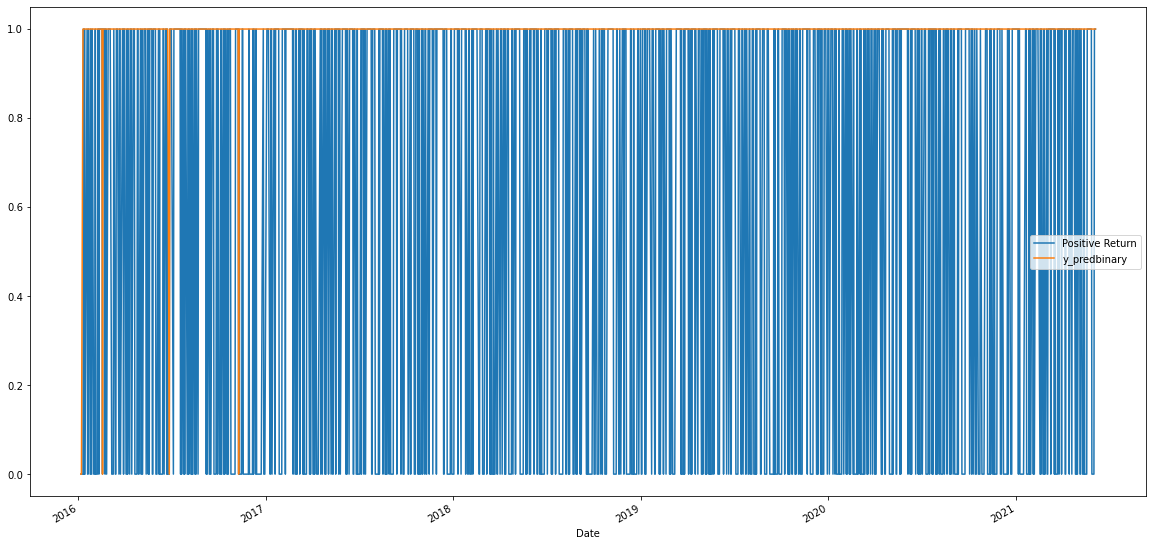

In [440]:
results.plot(figsize=(20, 10))


In [495]:
results['daily_return'] = sig_df['daily_return']

results['Close'] = sig_df['Close']
results['final_prediction'] = fl_df['final_prediction']

/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sinan/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:4: S

In [499]:
wallet = 1000
equity = 0
num_stocks = 0
wallet_history = []
equity_history = []
num_stocks_history = []

for i in range(0,5):
    if equity <= 0 and results['final_prediction'].iloc[i] == 'sell':
        
        if num_stocks > 0:
            equity = num_stocks * results['Close'].iloc[i]

        wallet_history.append(wallet)
        equity_history.append(equity)
        num_stocks_history.append(num_stocks)
        pass

    elif wallet > 0 and results['final_prediction'].iloc[i] == 'buy':
        equity = wallet    
        wallet = wallet - equity

        num_stocks = equity / results['Close'].iloc[i]
        
        if num_stocks > 0:
            equity = num_stocks * results['Close'].iloc[i]

        wallet_history.append(wallet)
        equity_history.append(equity)
        num_stocks_history.append(num_stocks)

    elif wallet <= 0 and results['final_prediction'].iloc[i] == 'buy':

        if num_stocks > 0:
            equity = num_stocks * results['Close'].iloc[i]
            
        wallet_history.append(wallet)
        equity_history.append(equity)
        num_stocks_history.append(num_stocks)    
    

In [501]:
wallet_history,equity_history,num_stocks_history

([1000, 1000, 0, 0, 0],
 [0, 0, 1000, 1002.8257567826658, 953.6567848765329],
 [0, 0, 11.973542592622028, 11.973542592622028, 11.973542592622028])

In [502]:
results

,Positive Return,y_predbinary,daily_return,Close,final_prediction
Date,,,,,
2016-01-07,0.0,0,-0.031463,86.019112,sell
2016-01-08,0.0,0,-0.028643,83.555260,sell
2016-01-11,0.0,1,-0.000452,83.517471,buy
2016-01-12,1.0,1,0.002826,83.753471,buy
2016-01-13,0.0,1,-0.049030,79.647003,buy
...,...,...,...,...,...
2021-05-28,0.0,1,-0.002812,379.470001,buy
2021-06-01,0.0,1,-0.015838,373.459991,buy
2021-06-02,1.0,1,0.017057,379.829987,buy


In [498]:
results

,Positive Return,y_predbinary,daily_return,Close,final_prediction
Date,,,,,
2016-01-07,0.0,0,-0.031463,86.019112,sell
2016-01-08,0.0,0,-0.028643,83.555260,sell
2016-01-11,0.0,1,-0.000452,83.517471,buy
2016-01-12,1.0,1,0.002826,83.753471,buy
2016-01-13,0.0,1,-0.049030,79.647003,buy
...,...,...,...,...,...
2021-05-28,0.0,1,-0.002812,379.470001,buy
2021-06-01,0.0,1,-0.015838,373.459991,buy
2021-06-02,1.0,1,0.017057,379.829987,buy


<AxesSubplot:xlabel='Date'>

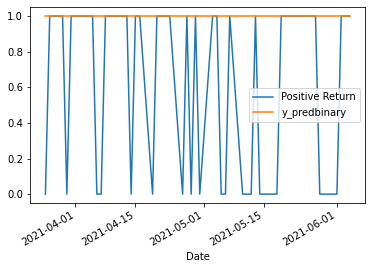

In [462]:
results[['Positive Return', 'y_predbinary']].tail(50).plot()

In [447]:
results

,Positive Return,y_predbinary,daily_return
Date,,,
2016-01-07,0.0,0,-0.031463
2016-01-08,0.0,0,-0.028643
2016-01-11,0.0,1,-0.000452
2016-01-12,1.0,1,0.002826
2016-01-13,0.0,1,-0.049030
...,...,...,...
2021-05-28,0.0,1,-0.002812
2021-06-01,0.0,1,-0.015838
2021-06-02,1.0,1,0.017057


<AxesSubplot:xlabel='Date'>

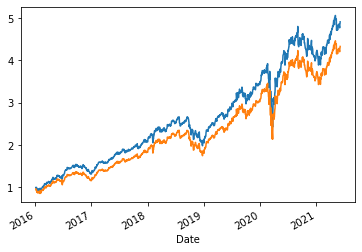

In [451]:
#Compare
(1 + (results['daily_return'] * results['y_predbinary'])).cumprod().plot()

(1 + results['daily_return']).cumprod().plot()

In [466]:
#Feature importance


# Get numerical feature importances
importances = list(rf.feature_importances_)

importances

[0.3410145829005046, 0.3162278704111159, 0.3427575466883796]

In [467]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: crossover_real       Importance: 0.34
Variable: bollinger_signal     Importance: 0.34
Variable: vol_trend_signal     Importance: 0.32


In [468]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification

In [469]:
# # Fit a SKLearn linear regression using just the training set (X_train, Y_train):
# model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
# model.fit(X_train, y_train)

# # Make a prediction of "y" values from the X_test dataset
# predictions = model.predict(X_test)

# # Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
# Results = y_test.to_frame()
# Results["Predicted Value"] = predictions
# Results

In [470]:
# Results.plot(figsize=(20, 10))


In [471]:
# Results[['Positive Return', 'Predicted Value']].tail(10).plot()

In [472]:
# # Replace predicted values 0 to -1 to account for shorting
# Results['Predicted Value'].replace(0, -1, inplace=True)
# Results

In [473]:
# Results["Returns"] = sig_df['daily_return']

# Results

In [474]:
# # Calculate cumulative return of model and plot the result
# (1 + (Results['Returns'] * Results['Predicted Value'])).cumprod().plot()

In [475]:
#  # Set initial capital allocation
# initial_capital = 10000

# # Plot cumulative return of model in terms of capital
# cumulative_return_capital = initial_capital * (1 + (Results['Returns'] * Results['Predicted Value'])).cumprod()
# cumulative_return_capital.plot()

In [476]:
# #Actual returns
# cumulative_returns['SPGI'].loc['2019-01-01':'2020-01-01'].plot()

In [477]:
# #Compared
# (1 + (Results['Returns'] * Results['Predicted Value'])).cumprod().plot()
# cumulative_returns['SPGI'].loc['2019-01-01':'2020-01-01'].plot()

In [250]:
#cumulative_returns.hvplot(label='Cumulative Returns', xlabel='Year', ylabel='Percent', height=800, width=1600)



#### Pick models

#### ARIMA Model


In [34]:
def getCovidData(csv):
    
    csvpath = Path('Resources/COVID_Data/' + csv)
    data = pd.read_csv(csvpath, index_col="Day")
    
    cleaned_data = data.loc[data['Code'] == 'USA'].drop(columns=['Entity', 'Code'])
    
    return cleaned_data

In [35]:
testing_pol = getCovidData('covid-19-testing-policy.csv')
contact_tr = getCovidData('covid-contact-tracing.csv')
vax_pol = getCovidData('covid-vaccination-policy.csv')
debt_relief = getCovidData('debt-relief-covid.csv')
face_cover = getCovidData('face-covering-policies-covid.csv')
income_support = getCovidData('income-support-covid.csv')
internal_mov = getCovidData('internal-movement-covid.csv')
int_travel = getCovidData('international-travel-covid.csv')
public_camp = getCovidData('public-campaigns-covid.csv')
public_events = getCovidData('public-events-covid.csv')
public_gather = getCovidData('public-gathering-rules-covid.csv')
public_trans = getCovidData('public-transport-covid.csv')
stay_home = getCovidData('stay-at-home-covid.csv')
work_close = getCovidData('workplace-closures-covid.csv')
school_close = getCovidData('school-closures-covid.csv')
stringency = getCovidData('covid-stringency-index.csv')

covid_data = pd.concat([testing_pol, contact_tr, vax_pol, debt_relief, face_cover, income_support, internal_mov,
                       int_travel, public_camp, public_events, public_gather, public_trans, stay_home, work_close,
                       school_close, stringency
                       ], axis="columns", join="outer")


covid_data

,testing_policy,contact_tracing,vaccination_policy,debt_relief,facial_coverings,income_support,restrictions_internal_movements,international_travel_controls,public_information_campaigns,cancel_public_events,restriction_gatherings,close_public_transport,stay_home_requirements,workplace_closures,school_closures,stringency_index
Day,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31
2021-05-19,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31
2021-05-20,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31


In [36]:
covid_data.isnull().sum()

testing_policy                      0
contact_tracing                     0
vaccination_policy                  0
debt_relief                         0
facial_coverings                    0
income_support                      0
restrictions_internal_movements     0
international_travel_controls       0
public_information_campaigns        0
cancel_public_events                0
restriction_gatherings              0
close_public_transport              0
stay_home_requirements              0
workplace_closures                  0
school_closures                    20
stringency_index                   20
dtype: int64

In [39]:
#Replace nulls with 0s, in this case Null values are where there is either no data or N/A hence, 0.
covid_data['school_closures'] = covid_data['school_closures'].fillna(0)
covid_data['stringency_index'] = covid_data['stringency_index'].fillna(0)


In [40]:
covid_data.isnull().sum()

testing_policy                     0
contact_tracing                    0
vaccination_policy                 0
debt_relief                        0
facial_coverings                   0
income_support                     0
restrictions_internal_movements    0
international_travel_controls      0
public_information_campaigns       0
cancel_public_events               0
restriction_gatherings             0
close_public_transport             0
stay_home_requirements             0
workplace_closures                 0
school_closures                    0
stringency_index                   0
dtype: int64

In [41]:
covid_data

,testing_policy,contact_tracing,vaccination_policy,debt_relief,facial_coverings,income_support,restrictions_internal_movements,international_travel_controls,public_information_campaigns,cancel_public_events,restriction_gatherings,close_public_transport,stay_home_requirements,workplace_closures,school_closures,stringency_index
Day,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00
2020-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00
2020-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00
2020-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00
2020-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31
2021-05-19,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31
2021-05-20,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31


In [ ]:
def plot_fraud_rates(df, var_name): 
    plt.figure(figsize=(20,6))
    plt.scatter(df.index, df['fraud_rate']*100)
    plt.title("Historical fraud accounts rates by {}".format(var_name), fontsize=20)
    plt.xlabel(var_name)
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=90)

def plot_correlation(df, var_name):
    target_var = 'fraud_acct'
    df2 = pd.get_dummies(df[[var_name, target_var]], columns=[var_name])
    x_labels = []
    labels = list(df2.columns[1:])
    for i in range(0,len(labels)):
        x_labels.append(labels[i].split('_')[-1])

    df3 = df2.corrwith(df2.fraud_acct)[1:]
    df3.index = x_labels

    df3.plot.bar(
            figsize = (20, 10), title = "Correlation with {}".format(var_name), fontsize = 15, grid = True)
    plt.title("Correlation between {} and Fraud".format(var_name), fontsize=20)
    plt.xlabel(var_name, fontsize=20)
    plt.ylabel("Correlation with {}".format(target_var), fontsize=20)
    
plot_correlation(df, 'num_apps_same_phone')